<a href="https://colab.research.google.com/github/appersaravanan/AI_Assignment3/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import UpSampling2D,Input,BatchNormalization,Conv2D,Activation,Dropout,LeakyReLU,Flatten,Dense,Conv2DTranspose,Reshape

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam


import matplotlib.pyplot as plt
from random import randint
from keras.datasets import mnist
from tensorflow.data import Dataset
import time,os

from IPython import display




                                                                    

## Input is defined based on the mnist deminsion

In [2]:
#input shape. cifar images are 32*32 and with RGB color as 3
input_shape=(28,28,1)



#Discriminator part

In [3]:


def def_discriminator():
  d = Sequential();
  d.add(Conv2D(filters=32, kernel_size=(5, 5),  strides=(2,2) ,padding='same',input_shape=input_shape))
  d.add(LeakyReLU(0.2))
  d.add(Dropout(0.4))

  d.add(Conv2D(filters=64, kernel_size=(5, 5),  strides=(2,2), padding='same'))
  d.add(LeakyReLU(0.2))
  d.add(Dropout(0.4))

  d.add(Conv2D(filters=128, kernel_size=(5, 5),  strides=(2,2), padding='same'))
  d.add(LeakyReLU(0.2))
  d.add(Dropout(0.4))

  d.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(2,2), padding='same'))
  d.add(LeakyReLU(0.2))
  d.add(Dropout(0.4))
  d.add(Flatten())
  d.add(Dense(1,activation='sigmoid'))
  img= Input(shape=input_shape)
  validity=d(img)
  return Model(img,validity)




#Generator

In [4]:
dim=7
depth=192

def def_generator ():
  g= Sequential()

  g.add( Dense(dim*dim*depth,input_dim=100 )) 
  g.add( BatchNormalization())
  g.add( Activation('relu'))

  g.add( Reshape((dim, dim, depth)))
  g.add( Dropout(0.4))
  g.add(UpSampling2D((2, 2)))

  g.add( Conv2DTranspose(filters=96, kernel_size=(5, 5), strides=1, padding='same') )
  g.add(BatchNormalization())
  g.add( Activation('relu'))
  g.add( UpSampling2D((2, 2)))

  g.add( Conv2DTranspose(filters=48, kernel_size=(5, 5), strides=1, padding='same'))
  g.add(BatchNormalization())

  g.add( Activation('relu'))


  g.add(Conv2DTranspose(filters=24, kernel_size=(5, 5), strides=1, padding='same'))
  g.add( BatchNormalization())
  g.add( Activation('relu'))


  g.add( Conv2DTranspose(filters=1, kernel_size=(5, 5), strides=1, padding='same')) 
  
  g.add(Activation('sigmoid'))
  #generator.compile (loss='binary_crossentropy',optimizer=RMSprop(lr=0.0001, decay=3e-8), metrics=['accuracy'] )

  #g.summary()
  noise=Input(shape=(100,))
  img =g(noise)

  return Model(noise,img);


In [5]:
batch_size=256
(x_train, y_train), (x_test, y_test) = mnist.load_data()
 


11493376/11490434 [==============================] - 2s 0us/step


# Normalization
Generator Last layer is sigmoid so the normilization need to be (0,1)

In [6]:
#print(x_train.min() , x_train.max())
x_train = x_train- x_train.min() / x_train.max()- x_train.min()
x_train =x_train/255
#print(x_train.min() , x_train.max())

x_train = np.expand_dims(x_train, axis=3) 

half_batch = int(batch_size / 2)

In [7]:

def train(epochs, batch_size=128, save_interval=50):

    for epoch in range(epochs):
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        imgs = x_train[idx] 
        noise = np.random.normal(0, 1, (half_batch, 100))
        gen_imgs = generator.predict(noise)
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        d_loss = d_loss_real +  d_loss_fake
        noise = np.random.normal(0, 1, (batch_size, 100)) 
        valid_y = np.array([1] * batch_size) #Creates an array of all ones of size=batch size
        g_loss = combined.train_on_batch(noise, valid_y)
        graph_data.append((d_loss[0], g_loss))
        # If at save interval => save generated image samples
        if epoch % save_interval == 0 or (epoch == epochs or  epoch == epochs-1) :
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            save_imgs(epoch)


image_array=[]
def save_imgs(epoch):
    
    noise = np.random.normal(0, 1, (16, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    image_array.append(gen_imgs)
    fig, axs = plt.subplots(4, 4)
    cnt = 0
    for i in range(4):
        for j in range(4):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    
    
    plt.show()


0 [D loss: 0.689294, acc.: 64.06%] [G loss: 0.666932]


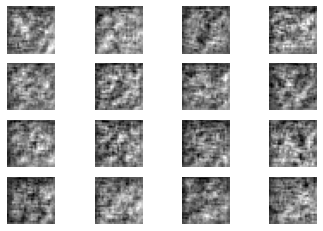

1000 [D loss: 0.734214, acc.: 48.44%] [G loss: 0.773775]


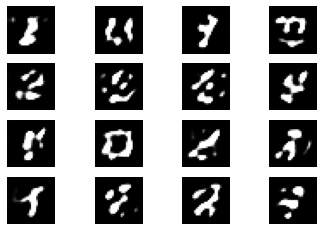

2000 [D loss: 0.705489, acc.: 41.41%] [G loss: 0.756375]


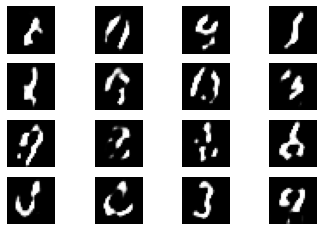

3000 [D loss: 0.417244, acc.: 92.19%] [G loss: 0.704995]


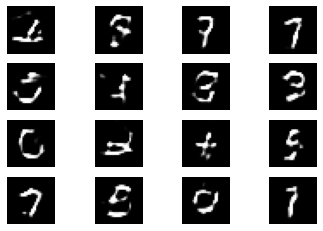

4000 [D loss: 0.577718, acc.: 68.75%] [G loss: 0.999311]


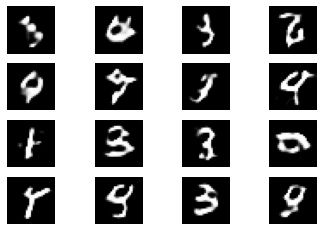

5000 [D loss: 0.509743, acc.: 76.56%] [G loss: 0.914695]


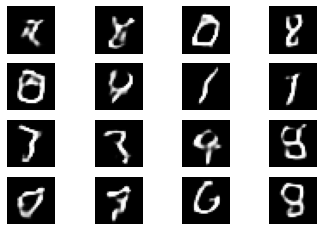

6000 [D loss: 0.633488, acc.: 66.41%] [G loss: 0.907156]


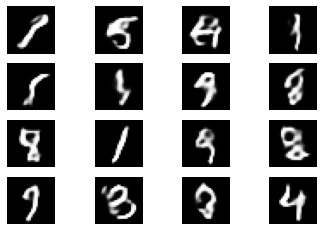

In [ ]:
discriminator = def_discriminator()
optimizer = Adam(0.0001) 
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])


generator = def_generator()
# generator.compile(loss='binary_crossentropy', optimizer=optimizer)

z = Input(shape=(100,))  
img = generator(z)

discriminator.trainable = False  

valid = discriminator(img)  #Validity check on the generated image



combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

graph_data=[]
train(epochs=15000, batch_size=64, save_interval=1000)

In [ ]:

# print( os.listdir() )m 
# print(os.getcwd())
# from google.colab import files
# files.download( "gan_4999.png" ) 



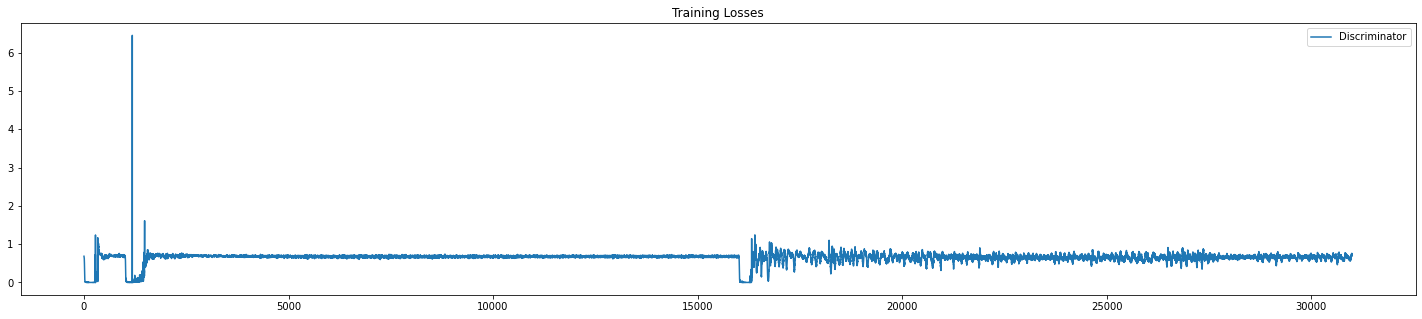

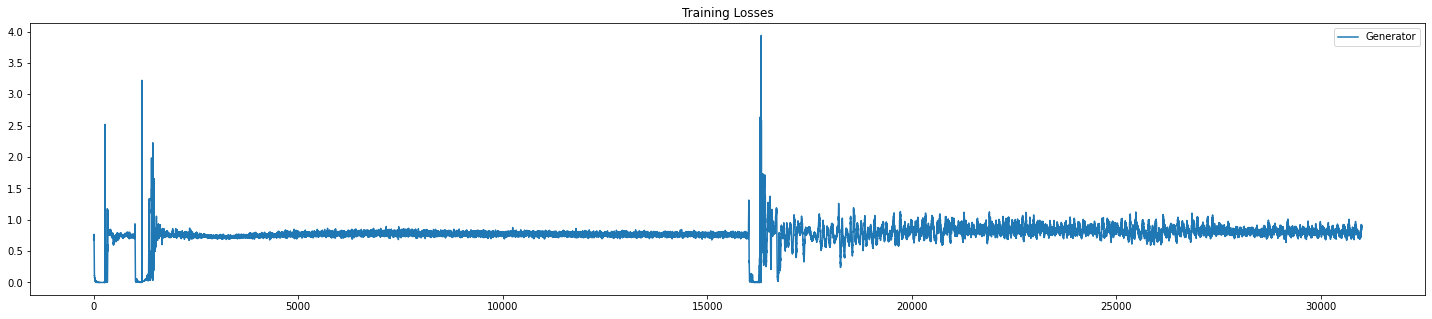

In [21]:
losses = np.array(graph_data)


fig, ax = plt.subplots(figsize=(25, 5))
plt.plot(losses.T[0], label='Discriminator')


plt.title("Training Losses")
plt.legend()


fig, ax = plt.subplots(figsize=(25, 5))


plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [ ]:

# def train_step(images):
#     noise = np.random.randn(100, 100).astype("float32")

#     with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#       generated_images = generator(noise, training=True)
#       #print(generated_images)
#       real_output = dis_model(images, training=True)
#       #print(real_output)
#       fake_output = dis_model(generated_images, training=True)
#       #print(fake_output)
#       gen_loss = generator_loss(fake_output)
#       # print(gen_loss)
#       disc_loss = discriminator_loss(real_output, fake_output)

#     gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
#     gradients_of_discriminator = disc_tape.gradient(disc_loss, dis_model.trainable_variables)

#     generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
#     discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, dis_model.trainable_variables))
#     #print(gen_loss)
#     print("gen loss: ", np.mean(gen_loss))
#     print("dis loss: " ,np.mean(disc_loss))


In [ ]:
# def train(ds,epochs):
#   for i in range(epochs):
#     for images in ds:
#       # images= tf.cast(images,tf.dtypes.float32)
#       train_step(images)
# train(x_train_ds,1)

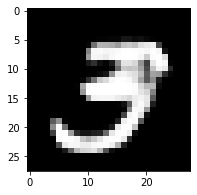

In [19]:
plt.subplots(figsize=(3, 3))
plt.imshow(tf.reshape(generator(np.random.randn(1,100)),(28,28)),cmap="gray")